In [ ]:
''' 
    AutoRec
    https://github.com/NeWnIx5991/AutoRec-for-CF
'''

In [64]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import time
import argparse
import torch.utils.data as Data
import torch.optim as optim
import matplotlib.pyplot as plt 

In [54]:
def get_data(path,num_users,num_items,num_total_ratings,train_ratio):

    fp = open(path + "ratings.dat")

    user_train_set = set()
    user_test_set = set()
    item_train_set = set()
    item_test_set = set()

    train_r = np.zeros((num_users, num_items))
    test_r = np.zeros((num_users, num_items))

    train_mask_r = np.zeros((num_users, num_items))
    test_mask_r = np.zeros((num_users, num_items))

    random_perm_idx = np.random.permutation(num_total_ratings)
    train_idx = random_perm_idx[0:int(num_total_ratings * train_ratio)]
    test_idx = random_perm_idx[int(num_total_ratings * train_ratio):]

    lines = fp.readlines()

    ''' Train '''
    for itr in train_idx:
        line = lines[itr]
        user, item, rating, _ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        train_r[user_idx, item_idx] = int(rating)
        train_mask_r[user_idx, item_idx] = 1

        user_train_set.add(user_idx)
        item_train_set.add(item_idx)

    ''' Test '''
    for itr in test_idx:
        line = lines[itr]
        user, item, rating, _ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        test_r[user_idx, item_idx] = int(rating)
        test_mask_r[user_idx, item_idx] = 1

        user_test_set.add(user_idx)
        item_test_set.add(item_idx)


    return train_r,train_mask_r,test_r,test_mask_r,user_train_set,item_train_set,user_test_set,item_test_set

In [106]:
class Autorec(nn.Module):
    def __init__(self,params):
        super(Autorec, self).__init__()
        
        self.num_users = params['num_users']
        self.num_items = params['num_items']
        self.hidden_units = params['hidden_units']
        self.lambda_value = params['lambda_value']

        self.encoder = nn.Sequential(
            nn.Linear(self.num_items, self.hidden_units),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.hidden_units, self.num_items),
        )


    def forward(self,torch_input):

        encoder = self.encoder(torch_input)
        decoder = self.decoder(encoder)

        return decoder

    def loss(self,decoder,input,optimizer,mask_input):
        cost = 0
        temp2 = 0
        
        # 这里乘以mask是因为通过encoder和decoder之后出来的interaction matrix 不再是之前的0,1稀疏matrix
        # 而是稠密的matrix，但是我们只需要比如 user i 对 item j 的rating
        cost += (( decoder - input) * mask_input).pow(2).sum()
        rmse = cost

        for i in optimizer.param_groups: # optimizer.param_groups is a list containing dicts
            #i_list=[i for i in optimizer.param_groups[0].keys()]
            #print(i_list)
            for j in i['params']:
                print(type(j.data), j.shape,j.data.dim())
                if j.data.dim() == 2:
                    temp2 += torch.t(j.data).pow(2).sum()

        cost += temp2 * self.lambda_value * 0.5
        return cost,rmse

In [108]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    np.random.seed(233)

    # get the parameters
    df = pd.read_csv('/home/dm/Downloads/movielens1m/ratings.dat',sep='::', \
                 names = ['user','item','rating','time'],engine = 'python')
    
    # item id 最大是3952，user id 最大是6040
    num_users = max(set(df.user))
    num_items = max(set(df.item))
    num_total_ratings = len(df)
    train_ratio = 0.9
    
    learning_rate = 1e-3
    hidden_units = 500
    lambda_value = 1
    batch_size = 64
    EPOCH = 20
    
    # put parameters into dict
    params = {'num_users':num_users,'num_items':num_items,'hidden_units': hidden_units,'lambda_value':lambda_value}

    train_r,train_mask_r,test_r,test_mask_r,user_train_set,item_train_set ,user_test_set,item_test_set = \
    get_data('/home/dm/Downloads/movielens1m/',num_users,num_items,num_total_ratings, train_ratio)
    
    # build model
    rec = Autorec(params).to(device)
    # build optimizer
    optimizer = optim.Adam(rec.parameters(), lr = learning_rate, weight_decay = 1e-4)

    num_batch = int(math.ceil(num_users / batch_size))
    # prepare dataloader
    torch_dataset = Data.TensorDataset(torch.from_numpy(train_r),torch.from_numpy(train_mask_r),
                                       torch.from_numpy(train_r))
    loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    # train and test
    train_rmse = []
    test_rmse = []
    for epoch in range(EPOCH):
        # train --------------------------------
        RMSE = 0
        cost_all = 0
        for step, (batch_x, batch_mask_x, batch_y) in enumerate(loader):

            batch_x = batch_x.type(torch.FloatTensor).to(device)
            batch_mask_x = batch_mask_x.type(torch.FloatTensor).to(device)

            decoder = rec(batch_x)
            loss, rmse = rec.loss(decoder=decoder, input=batch_x, optimizer=optimizer, mask_input=batch_mask_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cost_all += loss
            RMSE += rmse

        RMSE = np.sqrt(RMSE.detach().cpu().numpy() / (train_mask_r == 1).sum())
        train_rmse.append(RMSE)
        print('epoch ', epoch,  ' train RMSE : ', RMSE)
        
        # test --------------------------------
        test_r_tensor = torch.from_numpy(test_r).type(torch.FloatTensor).to(device)
        test_mask_r_tensor = torch.from_numpy(test_mask_r).type(torch.FloatTensor).to(device)

        decoder = rec(test_r_tensor)
        #decoder = torch.from_numpy(np.clip(decoder.detach().cpu().numpy(),a_min=1,a_max=5)).cuda()

        unseen_user_test_list = list(user_test_set - user_train_set)
        unseen_item_test_list = list(item_test_set - item_train_set)

        for user in unseen_user_test_list:
            for item in unseen_item_test_list:
                if test_mask_r[user,item] == 1:
                    decoder[user,item] = 3

        mse = ((decoder - test_r_tensor) * test_mask_r_tensor).pow(2).sum()
        RMSE = mse.detach().cpu().numpy() / (test_mask_r == 1).sum()
        RMSE = np.sqrt(RMSE)
        test_rmse.append(RMSE)

        print('epoch ', epoch, ' test RMSE : ', RMSE)
    plt.plot(range(EPOCH),train_rmse,label = 'train')
    plt.plot(range(EPOCH),test_rmse,label = 'test')
    plt.legend()

epoch  0  train RMSE :  1.3232717987071911
epoch  0  test RMSE :  1.237658781593486
epoch  1  train RMSE :  1.0318069239072751
epoch  1  test RMSE :  1.1904039144715908
epoch  2  train RMSE :  1.0192827978342154
epoch  2  test RMSE :  1.192866661457548
epoch  3  train RMSE :  1.004748530071949
epoch  3  test RMSE :  1.1566832188959673
epoch  4  train RMSE :  0.989168485307535
epoch  4  test RMSE :  1.1447340234824206
epoch  5  train RMSE :  0.9707821233583694
epoch  5  test RMSE :  1.118851150686072
epoch  6  train RMSE :  0.9504006826631772
epoch  6  test RMSE :  1.0931246802039742
epoch  7  train RMSE :  0.9293675387558804
epoch  7  test RMSE :  1.0799186597353314
epoch  8  train RMSE :  0.9088393248676736
epoch  8  test RMSE :  1.0638191428901607
epoch  9  train RMSE :  0.8887999003216461
epoch  9  test RMSE :  1.0402339862542018
epoch  10  train RMSE :  0.8702506396939352
epoch  10  test RMSE :  1.0224606080329228
epoch  11  train RMSE :  0.8516049188859561
epoch  11  test RMSE :  

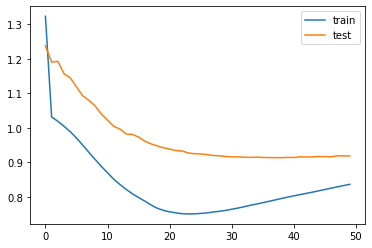

In [73]:
# epoch =50 ,lambda = 0.5
torch.cuda.synchronize()
start = time.time()

main()
end = time.time()
print('cost time:', end-start)